<a href="https://colab.research.google.com/github/sgparrot/sgparrot2021Lv1-1/blob/main/Simpsons_Classification_20210512_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simpsons Classification

In [ ]:
import os
import glob
import zipfile
 
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.model_selection import train_test_split
from pprint import pprint
### for notebook users
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## 저장된 npz 파일 불러오기
구글드라이브에서 불러오는 데에 상당히 오래 걸리기 때문에, 한 번 불러온 후 npz 파일로 저장해놓은 상황. <br>
만약에 저장하는 코드가 보고 싶으시다면 0508 파일 참고해주세요.

In [ ]:
target = ["bart", "charles_montgomery", "krusty", "lisa_simpson",
            "marge_simpson", "milhouse_van_houten", "moe_szyslak",
            "ned_flanders", "principal_skinner"]

category = {0: "bart", 1: "charles_montgomery", 2: "krusty", 3: "lisa_simpson",
            4: "marge_simpson", 5: "milhouse_van_houten", 6: "moe_szyslak",
            7: "ned_flanders", 8: "principal_skinner"}

In [ ]:
train_dataset = np.load("/content/drive/MyDrive/Colab Notebooks/simpsons/train_128_npz.npz")
test_dataset = np.load("/content/drive/MyDrive/Colab Notebooks/simpsons/test_128_npz.npz")

In [ ]:
X_train = train_dataset["X_train_npz"]
y_train = train_dataset["y_train_npz"]

y_train = to_categorical(y_train, len(target))

X_test = test_dataset["X_test_npz"]
y_test_list = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/simpsons/test_sample.csv")
y_test = np.array(y_test_list["files"])

In [ ]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))   # 아직 어떻게 할지 못 정함

X_train shape: (11248, 128, 128, 3)
y_train shape: (11248, 9)
X_test shape: (1086, 128, 128, 3)
y_test shape: (1086,)


## Data Processing & Data Inspection

In [ ]:
train_batch_size = 128
test_batch_size = 128
image_size = 128


### 그냥 원본으로 불러서 원하는 해상도로 crop할지 고민 중
augmentor_train = A.Compose([
                             A.HorizontalFlip(p=0.5),
                             A.ShiftScaleRotate(p=0.5),
                             A.RandomBrightnessContrast(
                                 brightness_limit=(-0.25, 0.25),
                                 contrast_limit=(-0.25, 0.25), p=1
                                 ),   # 밝기와 대비 조절
                             A.CLAHE(p=1),   # Contrast-Limited Adaptive Histogram Equalization
                             A.Cutout(num_holes = 16, max_h_size=2,
                                      max_w_size=2, p=0.75),   # dropout
                             A.Normalize(mean=(0, 0, 0), std=(1, 1, 1))
])
augmentor_test = A.Compose([A.Normalize(mean=(0, 0, 0), std=(1, 1, 1))])

### Defining Dataloader

In [ ]:
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size,
                 augmentor= None, shuffle=False):   # augmentor가 추가됨

        """
        x_set, y_set: train set or test set (np.ndarray)
        batch_size: the size of data when a batch is enumerated (int)
        augmentor: data augmentor (albumantation, imgaug, ...)
        shuffle: whether shuffle the data or not after each epoch (boolean)
        """

        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size: (idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        # batch_size 쓰면 마지막 batch에서 문제 발생
        # 대안으로 indices.shape[0] 사용
        image_batch = np.zeros((indices.shape[0], image_size, image_size, 3))

        for image_index in range(indices.shape[0]):

            ### 이 안에서 다룰지, 밖에서 해결할지 고민 중
            ### image = cv2.cvtColor(cv2.imdead(indices.shape[image_index]), cv2.COLOR_BGR2RGB)
            ### image = cv2.resize(image, (image_size, image_size))

            image = batch_x[image_index]

            if self.augmentor is not None:
                image = self.augmentor(image=image)["image"]

            batch_x[image_index] = image
        
        return np.array(batch_x), np.array(batch_y)
    
    ### Epoch이 한 번 끝날 때마다 shuffle
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
train_loader = Dataloader(train_data, train_labels, batch_size=train_batch_size,
                          augmentor=augmentor_train, shuffle=True)
val_loader = Dataloader(val_data, val_labels, batch_size=train_batch_size,
                        augmentor=augmentor_train, shuffle=True)
test_loader = Dataloader(X_test, y_test, batch_size=test_batch_size,
                         augmentor=augmentor_test, shuffle=False)

In [ ]:
### 임시로 1개의 batch를 돌려서 잘 작동하는지 확인(Train Set)
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (128, 9)
Data  : (128, 128, 128, 3)


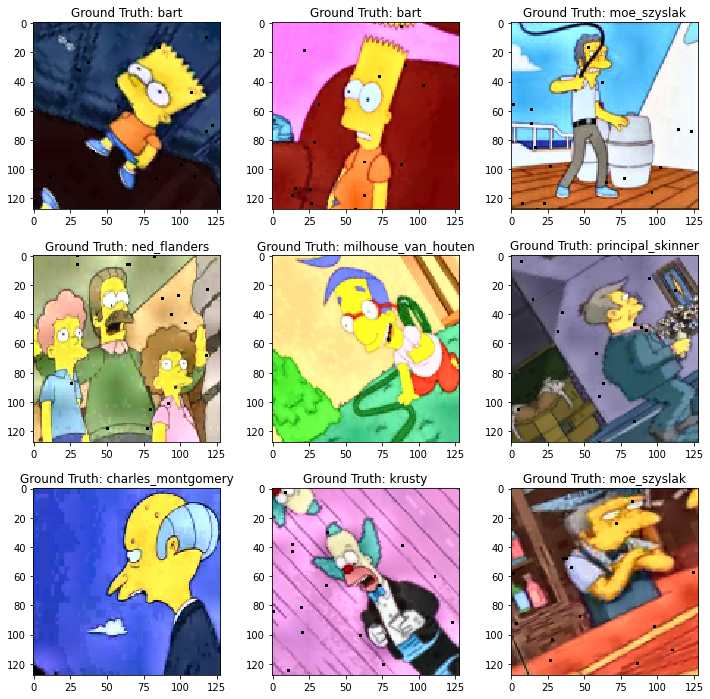

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="rainbow", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format(category.get(int(target))))

plt.show()

In [ ]:
### 임시로 1개의 batch를 돌려서 잘 작동하는지 확인(Test Set)
### Scaling을 제외한 Augmentation이 적용되면 안 됨!!!
examples = enumerate(test_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (128,)
Data  : (128, 128, 128, 3)


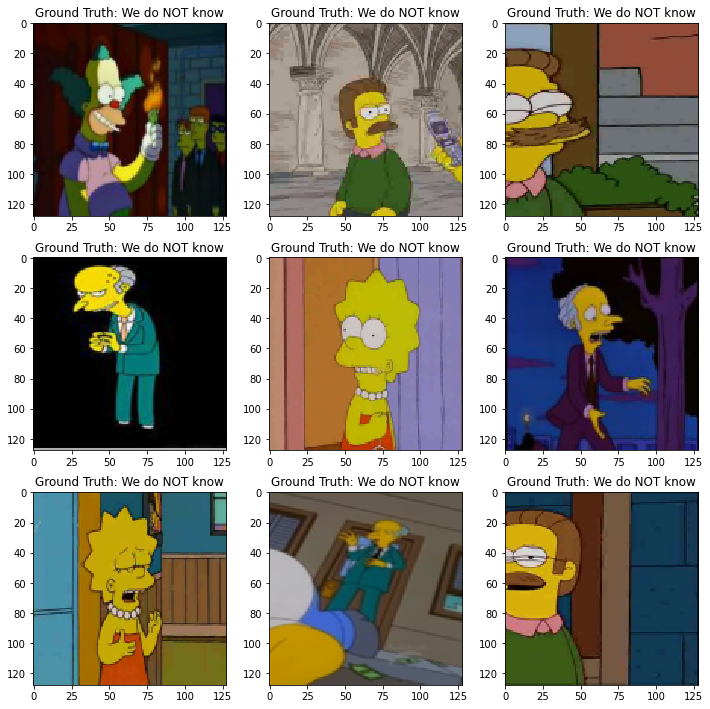

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="rainbow", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format("We do NOT know"))

plt.show()

## CNN Modeling

### ResNet 구현하기

#### Identity Block
Shorcut을 통하여 나중에 합쳐지는 부분. ResNet의 핵심.

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation
from tensorflow.keras.layers import add, Input
from tensorflow.keras.models import Model

In [ ]:
def identity_block(input_tensor, middle_kernel_size, filters, stage, block):
    """
    middle_kernel_size: 1 x 1을 제외한 conv layer size. 보통 3 x 3(권장) 혹은 5 x 5.
    filters: 3개의 conv layer들의 filter 갯수를 list 형태로 입력 받음.
            (ResNet 50, 101, 152를 생각하여 3개로 고정되어 있으나,
            18 혹은 34를 위해서 2개도 입력할 수 있도록 고려해보아야 함.)
    stage: residual block들 간의 구분을 위한 인자 (2, 3, 4, 5)
    block: 같은 stage 안에서의 identity_ block 구분을 위한 인자
    """


    filter1, filter2, filter3 = filters
    ### Layer가 너무 많아, 별도의 이름을 지정하기로 함
    conv_name_base = "res_{0}{1}_branch".format(str(stage), block)
    bn_name_base = "bn_{0}{1}_branch".format(str(stage), block)

    ### 1 x 1 Conv2D -> BatchNormalization -> ReLU
    ### ReLU가 아니어도 좋으나, sigmoid 등 (0, 0)을 지나는 않는 activation function은 피해야 함
    ### activation, initializer 등은 변수화 하여 args에 저장
    x = Conv2D(filters=filter1, kernel_size=(1, 1), kernel_initializer="he_normal", name=conv_name_base+"2a")(input_tensor)
    x = BatchNormalization(axis=-1, name=bn_name_base+"2a")(x)
    x = Activation("relu")(x)

    ### 3 x 3 Conv2D -> BatchNormalization -> ReLU
    x = Conv2D(filters=filter2, kernel_size=middle_kernel_size, padding="same", kernel_initializer="he_normal", name=conv_name_base+"2b")(x)
    x = BatchNormalization(axis=-1, name=bn_name_base+"2b")(x)
    x = Activation("relu")(x)

    ### 1 x 1 Conv2D -> BatchNormalization (ReLU는 합한 후 수행)
    ### filter의 size를 input_tensor에 맞게 복원
    x = Conv2D(filters=filter3, kernel_size=(1, 1), kernel_initializer="he_normal", name=conv_name_base+"2c")(x)
    x = BatchNormalization(axis=-1, name=bn_name_base+"2c")(x)



    ### Shortcut의 결과와 Residual Block의 결과를 합한 후 ReLU 적용
    x = add([x, input_tensor])   # x from Residual Block, input_tensor from Shorcut
    x = Activation("relu")(x)

    return x

In [ ]:
### 예시

input_tensor = Input(shape=(56, 56, 256), name="example_input")
filters = [64, 64, 256]   ## 1/4로 축소 후 마지막에 256으로 복원

kernel_size = (3, 3)
stage = 2
block = "a"

output = identity_block(input_tensor, kernel_size, filters, stage, block)
identity_layers = Model(inputs=input_tensor, outputs=output)
identity_layers.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
example_input (InputLayer)      [(None, 56, 56, 256) 0                                            
__________________________________________________________________________________________________
res_2a_branch2a (Conv2D)        (None, 56, 56, 64)   16448       example_input[0][0]              
__________________________________________________________________________________________________
bn_2a_branch2a (BatchNormalizat (None, 56, 56, 64)   256         res_2a_branch2a[0][0]            
__________________________________________________________________________________________________
activation (Activation)         (None, 56, 56, 64)   0           bn_2a_branch2a[0][0]             
______________________________________________________________________________________________

In [ ]:
### 이제 3개의 identity block을 묶어서 Stage 2를 마무리 지어보자

input_tensor = Input(shape=(56, 56, 256), name="example_input")
x = identity_block(input_tensor, middle_kernel_size=(3, 3), filters=[64, 64, 256], stage=2, block="a")
x = identity_block(x, middle_kernel_size=(3, 3), filters=[64, 64, 256], stage=2, block="b")
output = identity_block(x, middle_kernel_size=(3, 3), filters=[64, 64, 256], stage=2, block="c")

identity_layers = Model(inputs=input_tensor, outputs = output)
identity_layers.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
example_input (InputLayer)      [(None, 56, 56, 256) 0                                            
__________________________________________________________________________________________________
res_2a_branch2a (Conv2D)        (None, 56, 56, 64)   16448       example_input[0][0]              
__________________________________________________________________________________________________
bn_2a_branch2a (BatchNormalizat (None, 56, 56, 64)   256         res_2a_branch2a[0][0]            
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 56, 56, 64)   0           bn_2a_branch2a[0][0]             
____________________________________________________________________________________________

In [ ]:
def conv_block(input_tensor, middle_kernel_size, filters, stage, block, strides=(2, 2)):
    """
    middle_kernel_size: 1 x 1을 제외한 conv layer size. 보통 3 x 3(권장) 혹은 5 x 5.
    filters: 3개의 conv layer들의 filter 갯수를 list 형태로 입력 받음.
            (ResNet 50, 101, 152를 생각하여 3개로 고정되어 있으나,
            18 혹은 34를 위해서 2개도 입력할 수 있도록 고려해보아야 함.)
    stage: residual block들 간의 구분을 위한 인자 (2, 3, 4, 5)
    block: 같은 stage 안에서의 identity_ block 구분을 위한 인자
    strides: 매 stage 시작, feature map의 크기를 절반으로 줄여야 함
             단, 첫 stage의 경우 maxpooling으로 시작하기 때문에 반드시 (1, 1)로 설정할 것.
    """


    filter1, filter2, filter3 = filters
    ### Layer가 너무 많아, 별도의 이름을 지정하기로 함
    conv_name_base = "res_{0}{1}_branch".format(str(stage), block)
    bn_name_base = "bn_{0}{1}_branch".format(str(stage), block)

    ### 1 x 1 Conv2D -> BatchNormalization -> ReLU
    ### ReLU가 아니어도 좋으나, sigmoid 등 (0, 0)을 지나는 않는 activation function은 피해야 함
    ### activation, initializer 등은 변수화 하여 args에 저장
    x = Conv2D(filters=filter1, kernel_size=(1, 1), strides=strides, kernel_initializer="he_normal", name=conv_name_base+"2a")(input_tensor)
    x = BatchNormalization(axis=-1, name=bn_name_base+"2a")(x)
    x = Activation("relu")(x)

    ### 3 x 3 Conv2D -> BatchNormalization -> ReLU
    x = Conv2D(filters=filter2, kernel_size=middle_kernel_size, padding="same", kernel_initializer="he_normal", name=conv_name_base+"2b")(x)
    x = BatchNormalization(axis=-1, name=bn_name_base+"2b")(x)
    x = Activation("relu")(x)

    ### 1 x 1 Conv2D -> BatchNormalization (ReLU는 합한 후 수행)
    ### filter의 size를 input_tensor에 맞게 복원
    x = Conv2D(filters=filter3, kernel_size=(1, 1), kernel_initializer="he_normal", name=conv_name_base+"2c")(x)
    x = BatchNormalization(axis=-1, name=bn_name_base+"2c")(x)



    ### shorcut을 별도로 지정해주어야 함 (차원을 맞추기 위해)
    shortcut = Conv2D(filters=filter3, kernel_size= (1, 1), strides=strides, kernel_initializer="he_normal", name=conv_name_base+"1")(input_tensor)
    shortcut = BatchNormalization(axis=-1, name=bn_name_base+"1")(shortcut)

    ### Shortcut의 결과와 Residual Block의 결과를 합한 후 ReLU 적용
    x = add([x, shortcut])
    x = Activation("relu")(x)

    return x

In [ ]:
### conv_block()과 identity_block()

input_tensor = Input(shape=(56, 56, 256), name="example_input")
x = conv_block(input_tensor, middle_kernel_size=(3, 3), filters=[64, 64, 256], strides=(2, 2), stage=2, block="a")
x = identity_block(x, middle_kernel_size=(3, 3), filters=[64, 64, 256], stage=2, block="b")
output = identity_block(x, middle_kernel_size=(3, 3), filters=[64, 64, 256], stage=2, block="c")

identity_layers = Model(inputs=input_tensor, outputs = output)
identity_layers.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
example_input (InputLayer)      [(None, 56, 56, 256) 0                                            
__________________________________________________________________________________________________
res_2a_branch2a (Conv2D)        (None, 28, 28, 64)   16448       example_input[0][0]              
__________________________________________________________________________________________________
bn_2a_branch2a (BatchNormalizat (None, 28, 28, 64)   256         res_2a_branch2a[0][0]            
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 28, 28, 64)   0           bn_2a_branch2a[0][0]             
____________________________________________________________________________________________

#### Stage 1
7 x 7로 MaxPooling을 할 건데, 보통 나누어 떨어지지 않음. <br>
따라서 ZeroPadding을 실행할 것이고, 이것은 해상도에 맞게 조정해주어야 함. <br>
64 * 64, 128 * 128, 256 * 256 작동 <br>
Output = (I - F + 2P) / S + 1, where I: input_size, F: kernel_size, P: padding, S: stride

In [ ]:
from tensorflow.keras.layers import ZeroPadding2D, MaxPooling2D

In [ ]:
### 128 * 128 기준
def first_conv(input_tensor):

    x = ZeroPadding2D(padding=(3, 3), name="conv1_pad")(input_tensor)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding="valid", kernel_initializer="he_normal", name="conv")(x)
    x = BatchNormalization(axis=3, name="bn_cond1")(x)
    x = Activation("relu")(x)

    x = ZeroPadding2D(padding=(1, 1), name="pool1_pad")(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    return x

In [ ]:
input_tensor = Input(shape=(128, 128, 3))
output = first_conv(input_tensor)
model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 134, 134, 3)       0         
_________________________________________________________________
conv (Conv2D)                (None, 64, 64, 64)        9472      
_________________________________________________________________
bn_cond1 (BatchNormalization (None, 64, 64, 64)        256       
_________________________________________________________________
activation_21 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
pool1_pad (ZeroPadding2D)    (None, 66, 66, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0   

#### 전체 코드

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [ ]:
def ResNet(in_shape, n_classes):
    input_tensor = Input(shape=in_shape)



    ### Stage 1
    x = first_conv(input_tensor)

    ### Stage 2
    x = conv_block(x, middle_kernel_size=(3, 3), filters=[64, 64, 256], strides=(1, 1), stage=2, block="a")   # stride 주의
    x = identity_block(x, middle_kernel_size=(3, 3), filters=[64, 64, 256], stage=2, block="b")
    output = identity_block(x, middle_kernel_size=(3, 3), filters=[64, 64, 256], stage=2, block="c")

    ### Stage 3
    x = conv_block(x, middle_kernel_size=(3, 3), filters=[128, 128, 512], strides=(2, 2), stage=3, block="a")
    x = identity_block(x, middle_kernel_size=(3, 3), filters=[128, 128, 512], stage=3, block="b")
    x = identity_block(x, middle_kernel_size=(3, 3), filters=[128, 128, 512], stage=3, block="c")
    x = identity_block(x, middle_kernel_size=(3, 3), filters=[128, 128, 512], stage=3, block="d")

    ### Stage 4
    x = conv_block(x, middle_kernel_size=(3, 3), filters=[256, 256, 1024], strides=(2, 2), stage=4, block="a")
    x = identity_block(x, middle_kernel_size=(3, 3), filters=[256, 256, 1024], stage=4, block="b")
    x = identity_block(x, middle_kernel_size=(3, 3), filters=[256, 256, 1024], stage=4, block="c")
    x = identity_block(x, middle_kernel_size=(3, 3), filters=[256, 256, 1024], stage=4, block="d")
    x = identity_block(x, middle_kernel_size=(3, 3), filters=[256, 256, 1024], stage=4, block="e")
    x = identity_block(x, middle_kernel_size=(3, 3), filters=[256, 256, 1024], stage=4, block="f")

    ### Stage 5
    x = conv_block(x, middle_kernel_size=(3, 3), filters=[512, 512, 2048], strides=(2, 2), stage=5, block="a")
    x = identity_block(x, middle_kernel_size=(3, 3), filters=[512, 512, 2048], stage=5, block="b")
    x = identity_block(x, middle_kernel_size=(3, 3), filters=[512, 512, 2048], stage=5, block="c")

    ### FC 전에 GlobalAveragePooling
    x = GlobalAveragePooling2D(name="GlobalAveragePooling")(x)
    x = Dropout(rate=0.5)(x)   # 왜 0.5?
    x = Dense(128, activation="relu", name="FC_1")(x)
    x = Dropout(rate=0.5)(x)

    output = Dense(n_classes, activation="softmax", name="FC_2")(x)



    model = Model(inputs=input_tensor, outputs=output, name="ResNet_50")
    model.summary()

    return model

In [ ]:
model = ResNet((128, 128, 3), 9)

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv (Conv2D)                   (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_cond1 (BatchNormalization)   (None, 64, 64, 64)   256         conv[0][0]                       
__________________________________________________________________________________________

## Experiment


In [ ]:
earlystop = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=10,
                          verbose=1, mode="auto", baseline=None,
                          restore_best_weights=True)
learning_rate_reduction=ReduceLROnPlateau(monitor="val_accuracy", patience=3,
                                          verbose=1, factor=0.5, min_lr=0.0001)

### Cosine Decay Annealing
lr_Cosine_Decay = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=1e-3, first_decay_steps=128, 
    t_mul=1.5, m_mul=0.8, alpha=0.0, name=None
)

model.compile(optimizer=Adam(learning_rate=lr_Cosine_Decay), loss="categorical_crossentropy",
                  metrics=["accuracy"])
 
hist = model.fit(train_loader, batch_size=train_batch_size, epochs=100, validation_data=val_loader, verbose=1,
                 callbacks=[earlystop])

Epoch 1/100
71/71 [==============================] - 43s 536ms/step - loss: 2.6923 - accuracy: 0.1204 - val_loss: 2.1964 - val_accuracy: 0.1222
Epoch 2/100
71/71 [==============================] - 37s 522ms/step - loss: 2.1862 - accuracy: 0.1428 - val_loss: 2.1774 - val_accuracy: 0.1493
Epoch 3/100
71/71 [==============================] - 38s 529ms/step - loss: 2.1827 - accuracy: 0.1438 - val_loss: 2.1927 - val_accuracy: 0.1342
Epoch 4/100
71/71 [==============================] - 38s 530ms/step - loss: 2.1673 - accuracy: 0.1547 - val_loss: 2.1524 - val_accuracy: 0.1871
Epoch 5/100
71/71 [==============================] - 38s 527ms/step - loss: 2.1569 - accuracy: 0.1520 - val_loss: 2.1717 - val_accuracy: 0.1773
Epoch 6/100
71/71 [==============================] - 38s 528ms/step - loss: 2.1617 - accuracy: 0.1510 - val_loss: 2.0829 - val_accuracy: 0.1929
Epoch 7/100
71/71 [==============================] - 38s 526ms/step - loss: 2.1379 - accuracy: 0.1611 - val_loss: 2.0412 - val_accuracy:

In [ ]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

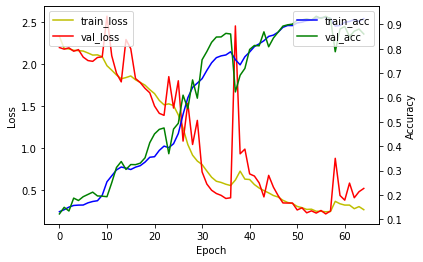

In [ ]:
acc_loss_plot(hist)

In [ ]:
y_test_list = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/simpsons/test_sample.csv")
del y_test_list["Unnamed: 0"]

print(y_test_list)

              files pred
0     test10013.jpg     
1     test10019.jpg     
2     test10028.jpg     
3     test10074.jpg     
4     test10084.jpg     
...             ...  ...
1081  test29955.jpg     
1082  test29959.jpg     
1083  test29963.jpg     
1084  test29984.jpg     
1085  test29998.jpg     

[1086 rows x 2 columns]


In [ ]:
### predict_classes 왜 deprecated됨?
# model.predict_classes(test_loader, batch_size=test_batch_size)
pred_integral = np.argmax(model.predict(test_loader), axis=-1)
print(len(pred_integral))
print(pred_integral)

1086
[2 7 7 ... 2 5 2]


In [ ]:
category = {0: "bart", 1: "charles_montgomery", 2: "krusty", 3: "lisa_simpson",
            4: "marge_simpson", 5: "milhouse_van_houten", 6: "moe_szyslak",
            7: "ned_flanders", 8: "principal_skinner"}

pred_categorical = []

for prediction in pred_integral:

    if 0 <= prediction <= 8:
        pred_categorical.append(category[prediction])
    
    else:
        raise ValueError("Not a valid integral prediction.")

print(pred_categorical)

['krusty', 'ned_flanders', 'ned_flanders', 'charles_montgomery', 'lisa_simpson', 'charles_montgomery', 'lisa_simpson', 'principal_skinner', 'ned_flanders', 'moe_szyslak', 'milhouse_van_houten', 'lisa_simpson', 'marge_simpson', 'bart', 'charles_montgomery', 'milhouse_van_houten', 'principal_skinner', 'bart', 'principal_skinner', 'principal_skinner', 'milhouse_van_houten', 'marge_simpson', 'moe_szyslak', 'moe_szyslak', 'marge_simpson', 'krusty', 'krusty', 'marge_simpson', 'bart', 'lisa_simpson', 'milhouse_van_houten', 'marge_simpson', 'krusty', 'milhouse_van_houten', 'marge_simpson', 'principal_skinner', 'bart', 'lisa_simpson', 'charles_montgomery', 'charles_montgomery', 'marge_simpson', 'principal_skinner', 'lisa_simpson', 'lisa_simpson', 'krusty', 'lisa_simpson', 'charles_montgomery', 'principal_skinner', 'bart', 'charles_montgomery', 'lisa_simpson', 'marge_simpson', 'moe_szyslak', 'principal_skinner', 'marge_simpson', 'bart', 'moe_szyslak', 'marge_simpson', 'krusty', 'milhouse_van_hou

## 기존 CNN Model

In [ ]:
from tensorflow.keras.models import Sequential

model=Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(9, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 64)      4864      
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 64)      102464    
_________________________________________________________________
batch_normalization_13 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 64)       

In [ ]:
earlystop = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=10,
                          verbose=1, mode="auto", baseline=None,
                          restore_best_weights=True)
learning_rate_reduction=ReduceLROnPlateau(monitor="val_accuracy", patience=3,
                                          verbose=1, factor=0.5, min_lr=0.0001)

### Cosine Decay Annealing
lr_Cosine_Decay = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=1e-3, first_decay_steps=128, 
    t_mul=2, m_mul=0.8, alpha=0.0, name=None
)

model.compile(optimizer=Adam(learning_rate=lr_Cosine_Decay), loss="categorical_crossentropy",
                  metrics=["accuracy"])
 
hist = model.fit(train_loader, batch_size=train_batch_size, epochs=100, validation_data=val_loader, verbose=1,
                 callbacks=[earlystop])

Epoch 1/100
71/71 [==============================] - 37s 504ms/step - loss: 2.3447 - accuracy: 0.3532 - val_loss: 2.7557 - val_accuracy: 0.1133
Epoch 2/100
71/71 [==============================] - 35s 489ms/step - loss: 1.3056 - accuracy: 0.5601 - val_loss: 2.7011 - val_accuracy: 0.1160
Epoch 3/100
71/71 [==============================] - 36s 498ms/step - loss: 1.2103 - accuracy: 0.5987 - val_loss: 2.8696 - val_accuracy: 0.1782
Epoch 4/100
71/71 [==============================] - 36s 500ms/step - loss: 0.9810 - accuracy: 0.6733 - val_loss: 2.8139 - val_accuracy: 0.1587
Epoch 5/100
71/71 [==============================] - 35s 493ms/step - loss: 0.7917 - accuracy: 0.7349 - val_loss: 2.0625 - val_accuracy: 0.2551
Epoch 6/100
71/71 [==============================] - 35s 497ms/step - loss: 0.7331 - accuracy: 0.7602 - val_loss: 2.3386 - val_accuracy: 0.2542
Epoch 7/100
71/71 [==============================] - 36s 499ms/step - loss: 0.6854 - accuracy: 0.7710 - val_loss: 1.8174 - val_accuracy:

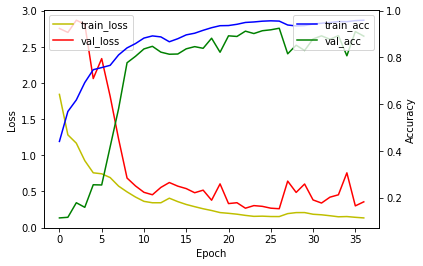

In [ ]:
acc_loss_plot(hist)

In [ ]:
y_test_list = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/simpsons/test_sample.csv")
del y_test_list["Unnamed: 0"]

print(y_test_list)

              files pred
0     test10013.jpg     
1     test10019.jpg     
2     test10028.jpg     
3     test10074.jpg     
4     test10084.jpg     
...             ...  ...
1081  test29955.jpg     
1082  test29959.jpg     
1083  test29963.jpg     
1084  test29984.jpg     
1085  test29998.jpg     

[1086 rows x 2 columns]


In [ ]:
### predict_classes 왜 deprecated됨?
# model.predict_classes(test_loader, batch_size=test_batch_size)
pred_integral = np.argmax(model.predict(test_loader), axis=-1)
print(len(pred_integral))
print(pred_integral)

1086
[2 7 7 ... 0 5 2]


In [ ]:
category = {0: "bart", 1: "charles_montgomery", 2: "krusty", 3: "lisa_simpson",
            4: "marge_simpson", 5: "milhouse_van_houten", 6: "moe_szyslak",
            7: "ned_flanders", 8: "principal_skinner"}

pred_categorical = []

for prediction in pred_integral:

    if 0 <= prediction <= 8:
        pred_categorical.append(category[prediction])
    
    else:
        raise ValueError("Not a valid integral prediction.")

In [ ]:
print(pred_categorical)

['krusty', 'ned_flanders', 'ned_flanders', 'charles_montgomery', 'lisa_simpson', 'charles_montgomery', 'lisa_simpson', 'principal_skinner', 'ned_flanders', 'moe_szyslak', 'milhouse_van_houten', 'lisa_simpson', 'marge_simpson', 'principal_skinner', 'lisa_simpson', 'milhouse_van_houten', 'principal_skinner', 'bart', 'principal_skinner', 'principal_skinner', 'milhouse_van_houten', 'marge_simpson', 'moe_szyslak', 'moe_szyslak', 'marge_simpson', 'krusty', 'krusty', 'marge_simpson', 'bart', 'lisa_simpson', 'milhouse_van_houten', 'marge_simpson', 'krusty', 'milhouse_van_houten', 'marge_simpson', 'principal_skinner', 'bart', 'lisa_simpson', 'charles_montgomery', 'charles_montgomery', 'marge_simpson', 'principal_skinner', 'lisa_simpson', 'lisa_simpson', 'krusty', 'lisa_simpson', 'charles_montgomery', 'principal_skinner', 'bart', 'charles_montgomery', 'lisa_simpson', 'marge_simpson', 'moe_szyslak', 'principal_skinner', 'marge_simpson', 'bart', 'moe_szyslak', 'marge_simpson', 'krusty', 'milhouse_